SetUp

In [ ]:
import pandas as pd
import xgboost as xgb
from sklearn.metrics import ndcg_score

# ========== Config ==========
TRAIN_FILE = "semantic_feature_dataset_final_ranked.csv"     # training dataset with label(Rank)
TEST_FILE = "semantic_feature_test_dataset.csv"              # test dataset 
MODEL_FILE = "xgb_ranking_model.ubj"
PREDICTIONS_FILE = "xgb_predicted_ranking_test.csv"

FEATURE_COLS = [
    "experience_semantic_score",
    "project_semantic_score",
    "publication_semantic_score",
    "skills_semantic_score",
    "education_semantic_score"
]

1. Train the Model

In [6]:
# Load training data
train_df = pd.read_csv(TRAIN_FILE)

# Ensure all feature columns are numeric
train_df[FEATURE_COLS] = train_df[FEATURE_COLS].apply(pd.to_numeric, errors="coerce").fillna(0.0)

# Prepare features and label (ranking)
X_train = train_df[FEATURE_COLS]
y_train = train_df["Label (Ranking)"].astype(int)

# Grouping per job
group_sizes = train_df.groupby("Job_ID").size().tolist()

# XGBoost DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dtrain.set_group(group_sizes)

# XGBoost Ranking parameters
params = {
    "objective": "rank:pairwise",
    "eta": 0.1,
    "gamma": 1.0,
    "min_child_weight": 0.1,
    "max_depth": 6,
    "verbosity": 1,
    "eval_metric": "ndcg"
}

# Train the model
model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    evals=[(dtrain, "train")],
    early_stopping_rounds=20
)

# Save model in binary format
model.save_model(MODEL_FILE)
print(f"-> Model trained and saved to: {MODEL_FILE}")


[0]	train-ndcg:0.73930
[1]	train-ndcg:0.91046
[2]	train-ndcg:0.90568
[3]	train-ndcg:0.90603
[4]	train-ndcg:0.94128
[5]	train-ndcg:0.96860


[6]	train-ndcg:0.99096
[7]	train-ndcg:0.99615
[8]	train-ndcg:0.99609
[9]	train-ndcg:0.99617
[10]	train-ndcg:0.99599
[11]	train-ndcg:0.99611
[12]	train-ndcg:0.99617
[13]	train-ndcg:0.99617
[14]	train-ndcg:0.99599
[15]	train-ndcg:0.99611
[16]	train-ndcg:0.99611
[17]	train-ndcg:0.99611
[18]	train-ndcg:0.99611
[19]	train-ndcg:0.99611
[20]	train-ndcg:0.99617
[21]	train-ndcg:0.99786
[22]	train-ndcg:0.99786
[23]	train-ndcg:0.99786
[24]	train-ndcg:0.99786
[25]	train-ndcg:0.99786
[26]	train-ndcg:0.99786
[27]	train-ndcg:0.99787
[28]	train-ndcg:0.99787
[29]	train-ndcg:0.99787
[30]	train-ndcg:0.99787
[31]	train-ndcg:0.99787
[32]	train-ndcg:0.99787
[33]	train-ndcg:0.99787
[34]	train-ndcg:0.99787
[35]	train-ndcg:0.99787
[36]	train-ndcg:0.99787
[37]	train-ndcg:0.99787
[38]	train-ndcg:0.99787
[39]	train-ndcg:0.99787
[40]	train-ndcg:0.99787
[41]	train-ndcg:0.99787
[42]	train-ndcg:0.99787
[43]	train-ndcg:0.99787
[44]	train-ndcg:0.99787
[45]	train-ndcg:0.99787
[46]	train-ndcg:0.99787
-> Model trained and

Evaluate

In [7]:
from sklearn.metrics import ndcg_score

# Predict scores on training data
train_preds = model.predict(dtrain)

# Combine predictions with Job_ID and true ranks
train_df["Predicted_Score"] = train_preds

# Compute NDCG per job
ndcg_per_job = []

for job_id, group in train_df.groupby("Job_ID"):
    true_relevance = group.sort_values("Label (Ranking)")["Label (Ranking)"].values.reshape(1, -1)
    predicted_scores = group.sort_values("Label (Ranking)")["Predicted_Score"].values.reshape(1, -1)
    
    ndcg = ndcg_score(true_relevance, predicted_scores)
    ndcg_per_job.append((job_id, ndcg))

# Convert to DataFrame and display average
ndcg_df = pd.DataFrame(ndcg_per_job, columns=["Job_ID", "NDCG"])
print(ndcg_df)

# Average NDCG across all jobs
avg_ndcg = ndcg_df["NDCG"].mean()
print(f"\n-> Average NDCG across all jobs: {avg_ndcg:.4f}")


   Job_ID      NDCG
0       1  1.000000
1       2  1.000000
2       3  1.000000
3       4  0.995631
4       5  1.000000
5       6  1.000000
6       7  1.000000
7       8  1.000000
8       9  1.000000
9      10  1.000000

-> Average NDCG across all jobs: 0.9996


Predict on Test Data set

In [8]:
#Load and prepare test dataset
test_df = pd.read_csv(TEST_FILE)
test_df[FEATURE_COLS] = test_df[FEATURE_COLS].apply(pd.to_numeric, errors="coerce").fillna(0.0)

# Predict using trained model
dtest = xgb.DMatrix(test_df[FEATURE_COLS])
test_df["Predicted_Score"] = model.predict(dtest)

# Rank candidates within each job using predicted score
test_df["Predicted_Rank"] = test_df.groupby("Job_ID")["Predicted_Score"] \
                                   .rank(method="dense", ascending=False).astype(int)

# Save final output
test_df = test_df.sort_values(["Job_ID", "Predicted_Rank"])
test_df.to_csv(PREDICTIONS_FILE, index=False)

print(f"Test predictions and rankings saved to: {PREDICTIONS_FILE}")


Test predictions and rankings saved to: xgb_predicted_ranking_test.csv


Candidate vs Job Ranking Prediction Explanation Plot

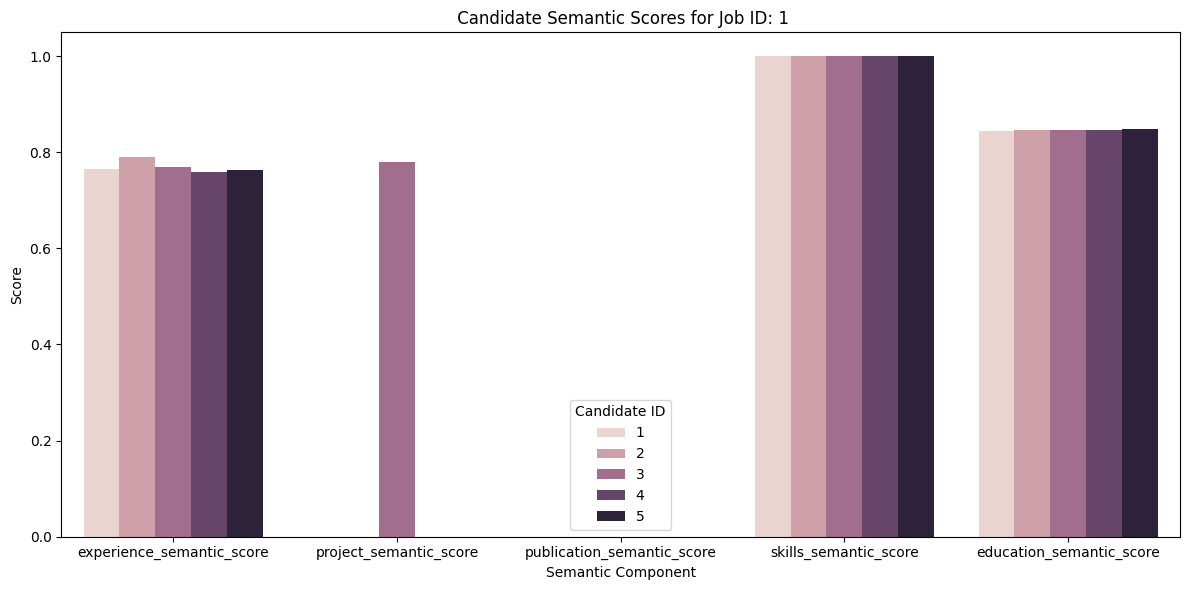

Predicted Ranking for Job 1:


,Candidate_ID,Predicted_Score,Predicted_Rank
0,1,0.453783,1
1,4,0.453783,1
2,5,0.357714,2
3,2,0.312760,3
4,3,-0.688498,4


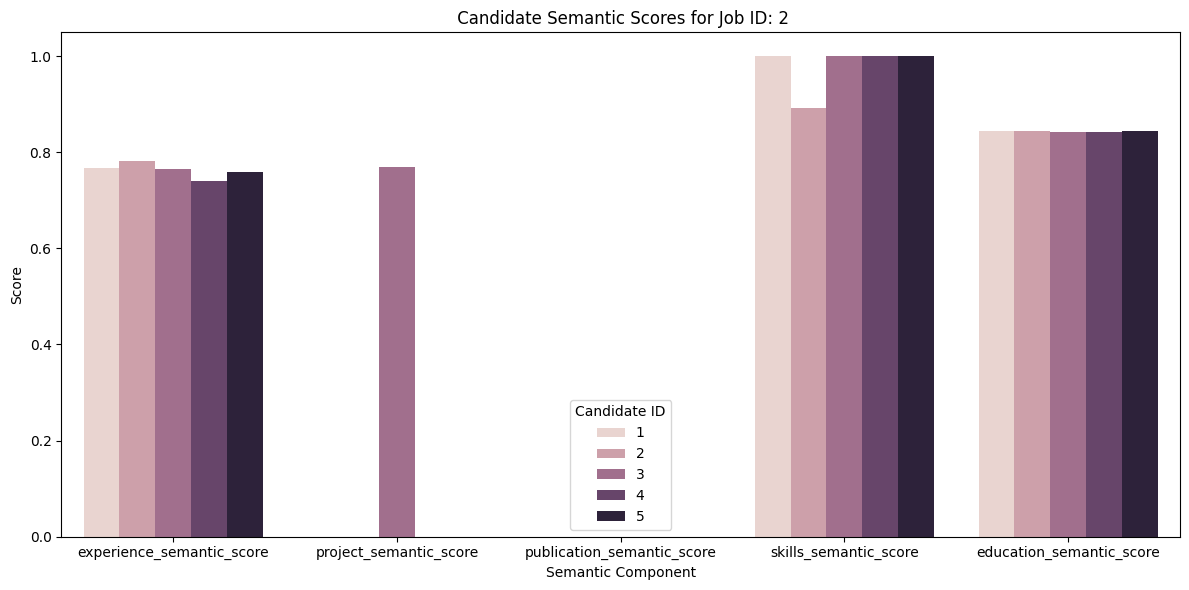

Predicted Ranking for Job 2:


,Candidate_ID,Predicted_Score,Predicted_Rank
5,4,0.766596,1
6,2,0.541682,2
7,1,0.453783,3
8,5,0.453783,3
9,3,-0.634916,4


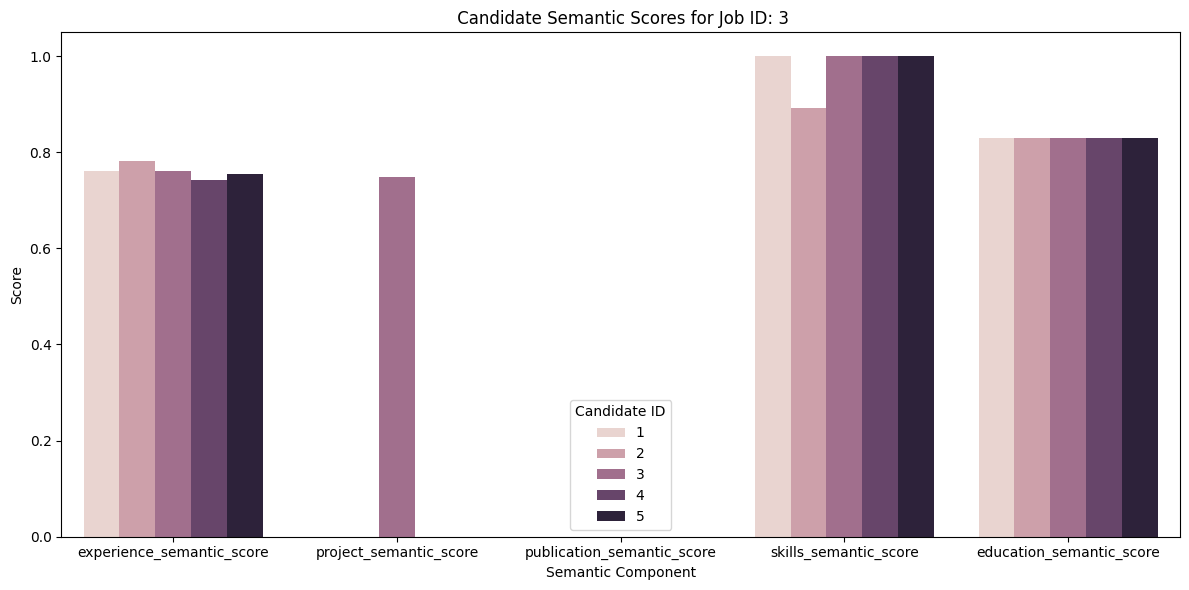

Predicted Ranking for Job 3:


,Candidate_ID,Predicted_Score,Predicted_Rank
10,4,0.705668,1
11,5,0.570431,2
12,2,0.480754,3
13,1,0.392856,4
14,3,0.392856,4


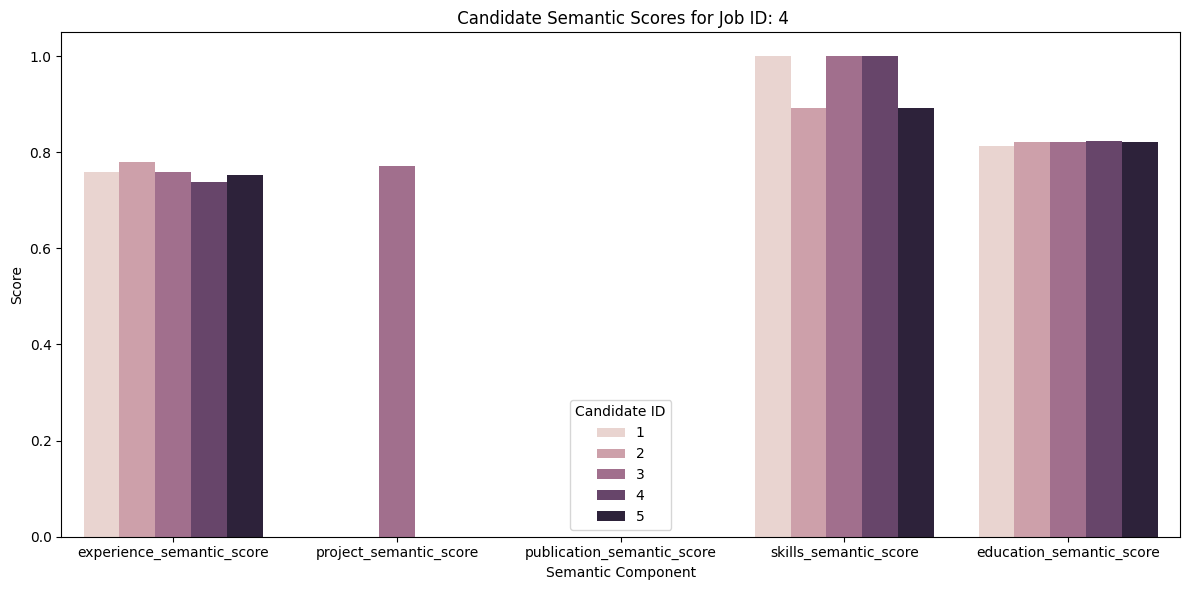

Predicted Ranking for Job 4:


,Candidate_ID,Predicted_Score,Predicted_Rank
15,5,0.858900,1
16,4,0.815431,2
17,2,0.480754,3
18,1,0.392856,4
19,3,-0.683562,5


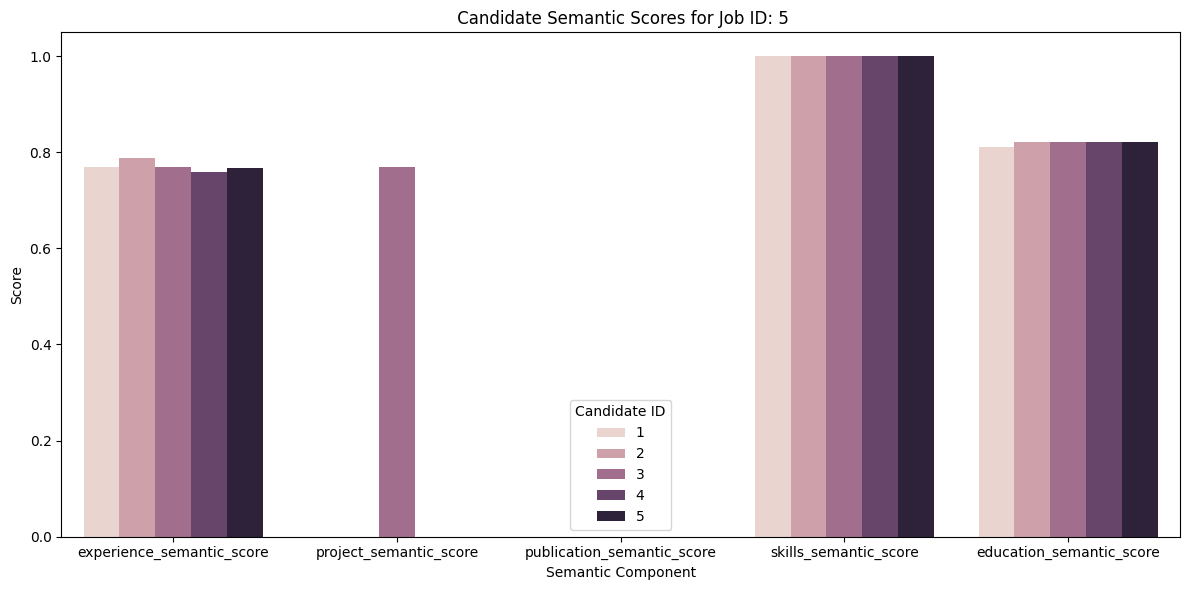

Predicted Ranking for Job 5:


,Candidate_ID,Predicted_Score,Predicted_Rank
20,4,0.392856,1
21,5,0.392856,1
22,1,0.381143,2
23,2,0.251832,3
24,3,-0.715372,4


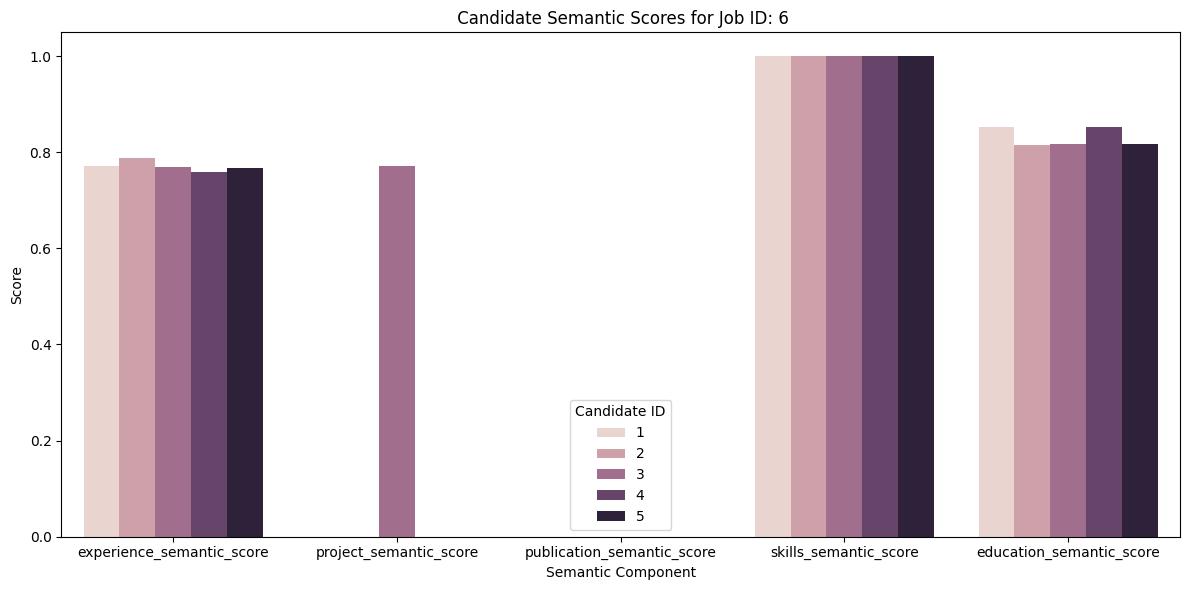

Predicted Ranking for Job 6:


,Candidate_ID,Predicted_Score,Predicted_Rank
25,5,0.392856,1
26,4,0.357714,2
27,1,0.346002,3
28,2,0.251832,4
29,3,-0.715372,5


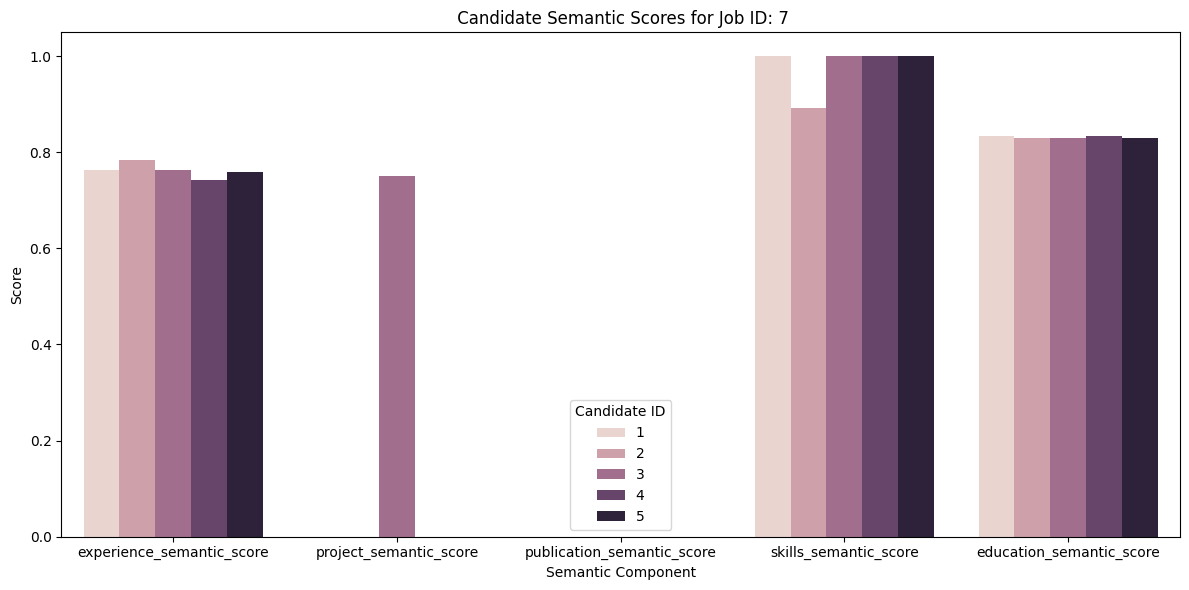

Predicted Ranking for Job 7:


,Candidate_ID,Predicted_Score,Predicted_Rank
30,4,0.705668,1
31,2,0.448089,2
32,1,0.392856,3
33,3,0.392856,3
34,5,0.392856,3


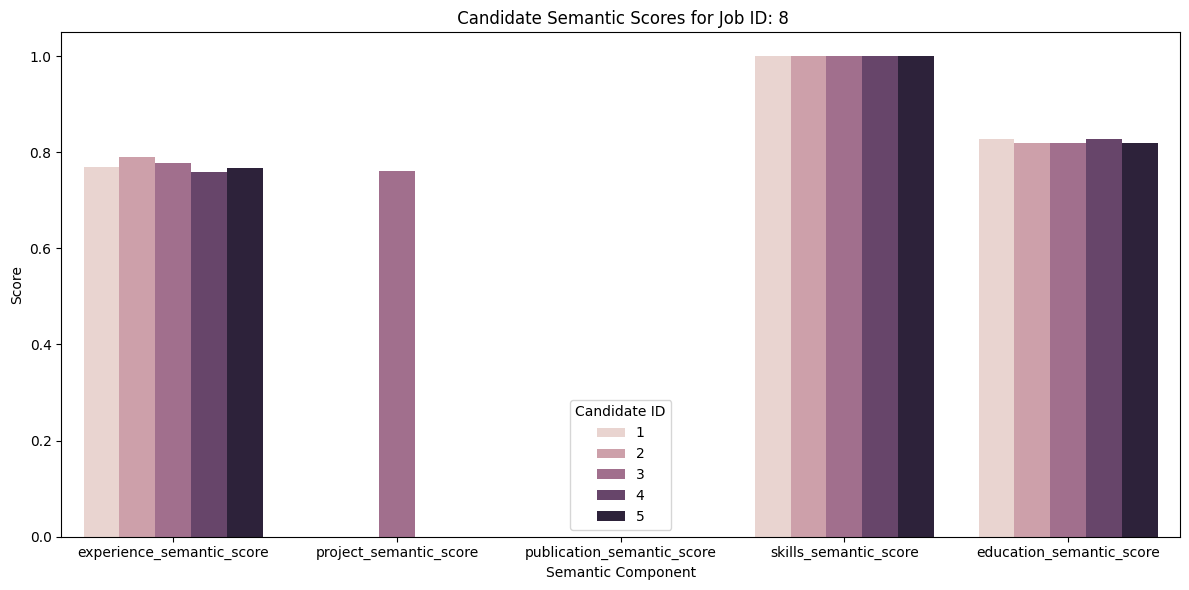

Predicted Ranking for Job 8:


,Candidate_ID,Predicted_Score,Predicted_Rank
35,1,0.392856,1
36,4,0.392856,1
37,5,0.392856,1
38,2,0.251832,2
39,3,-0.537866,3


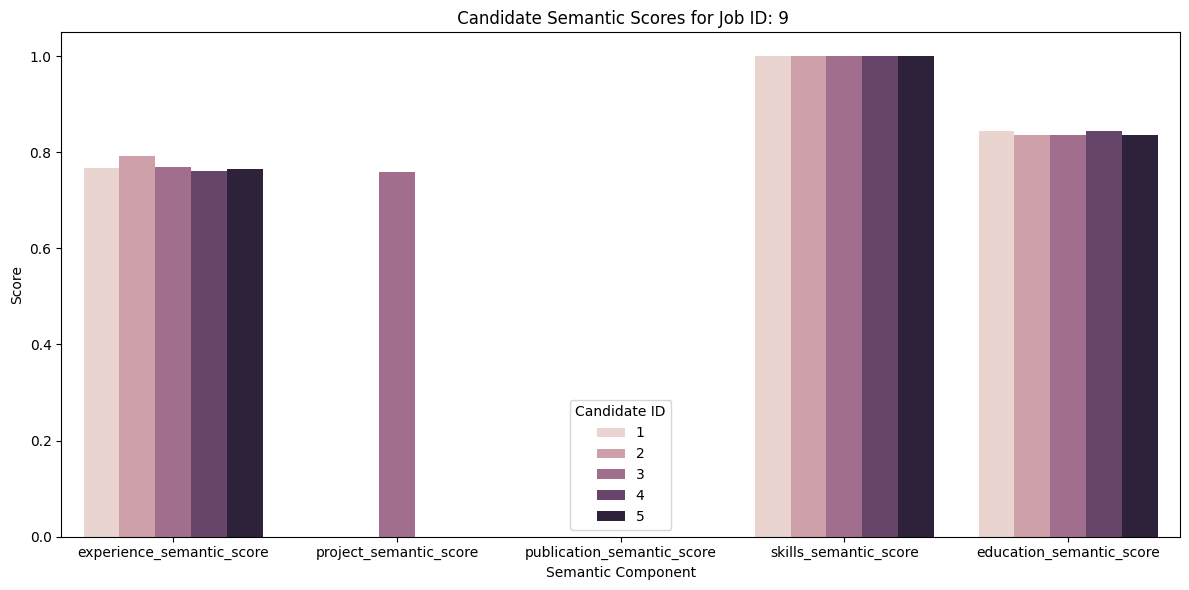

Predicted Ranking for Job 9:


,Candidate_ID,Predicted_Score,Predicted_Rank
40,1,0.453783,1
41,4,0.453783,1
42,5,0.453783,1
43,2,0.312760,2
44,3,-0.445756,3


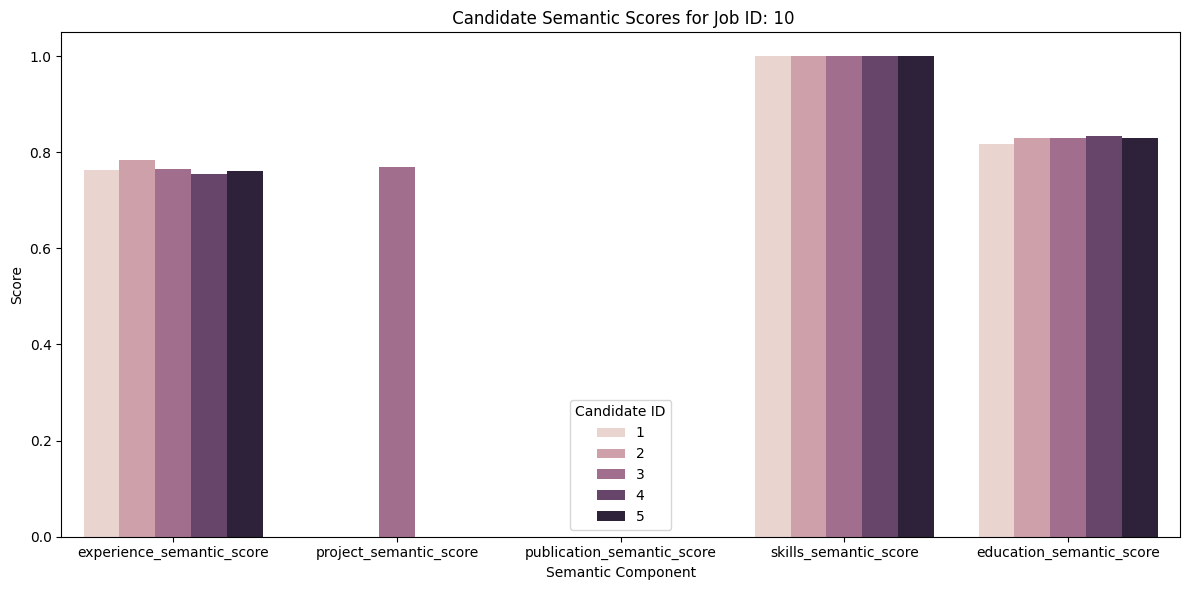

Predicted Ranking for Job 10:


,Candidate_ID,Predicted_Score,Predicted_Rank
45,4,0.570431,1
46,1,0.392856,2
47,5,0.392856,2
48,2,0.251832,3
49,3,-0.634916,4


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Load the predictions file
df = pd.read_csv(PREDICTIONS_FILE)

# Sort candidates within each job for clarity
df = df.sort_values(by=["Job_ID", "Predicted_Rank"])

# Plot per Job_ID
for job_id in df["Job_ID"].unique():
    job_df = df[df["Job_ID"] == job_id]

    # Melt semantic columns for grouped bar plot
    melted = job_df[["Candidate_ID", "Predicted_Rank"] + FEATURE_COLS].melt(
        id_vars=["Candidate_ID", "Predicted_Rank"],
        value_vars=FEATURE_COLS,
        var_name="Semantic Component",
        value_name="Score"
    )

    # Plot
    plt.figure(figsize=(12, 6))
    sns.barplot(
        data=melted,
        x="Semantic Component",
        y="Score",
        hue="Candidate_ID"
    )
    plt.title(f" Candidate Semantic Scores for Job ID: {job_id}")
    plt.ylabel("Score")
    plt.xlabel("Semantic Component")
    plt.legend(title="Candidate ID")
    plt.tight_layout()
    plt.show()

    # Optional: Also show predicted rank
    print(f"Predicted Ranking for Job {job_id}:")
    display(job_df[["Candidate_ID", "Predicted_Score", "Predicted_Rank"]].sort_values("Predicted_Rank"))
